# Определение стоимости автомобилей

    Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
    Необходимо построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
    Критерии, которые важны заказчику:
    - качество предсказания;
    - время обучения модели;
    - время предсказания модели.

## Шаг 1. Загрузите и подготовьте данные.

**1. Загрузка данных**

In [1]:
!pip3 install catboost

In [2]:
!pip install lightgbm

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    mean_squared_error,
    mean_absolute_error,
    recall_score
)
from sklearn.pipeline import(
    Pipeline, # Pipeline с ручным вводом названий шагов.
    make_pipeline # Pipeline с автоматическим названием шагов.
)
from time import time
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams ['figure.figsize'] = [10, 4]

In [4]:
try:
    data = pd.read_csv('C:/Users/almuc/Downloads/autos.csv', decimal = ',', parse_dates=['DateCreated', 'DateCrawled', 'LastSeen'])
except:
    data = pd.read_csv('/datasets/autos.csv', decimal = ',', parse_dates=['DateCreated', 'DateCrawled', 'LastSeen'])

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

В таблице 354369 строк и 16 столбцов. Пропуски в столбцах VehicleType, Gearbox,  Model, FuelType, Repaired.

In [7]:
data.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
Repaired                     object
DateCreated          datetime64[ns]
NumberOfPictures              int64
PostalCode                    int64
LastSeen             datetime64[ns]
dtype: object

Проверим названия столбцов.

In [8]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Нужно привести названия в нижний регистр.

In [9]:
data.columns = map(str.lower, data.columns)

In [10]:
data.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [11]:
data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [12]:
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Здесь мы видим значения которые выбиваются из межквартильных размахов, следовательно нужно будет провести работу с выбросами данных.

Построим гистограммы.

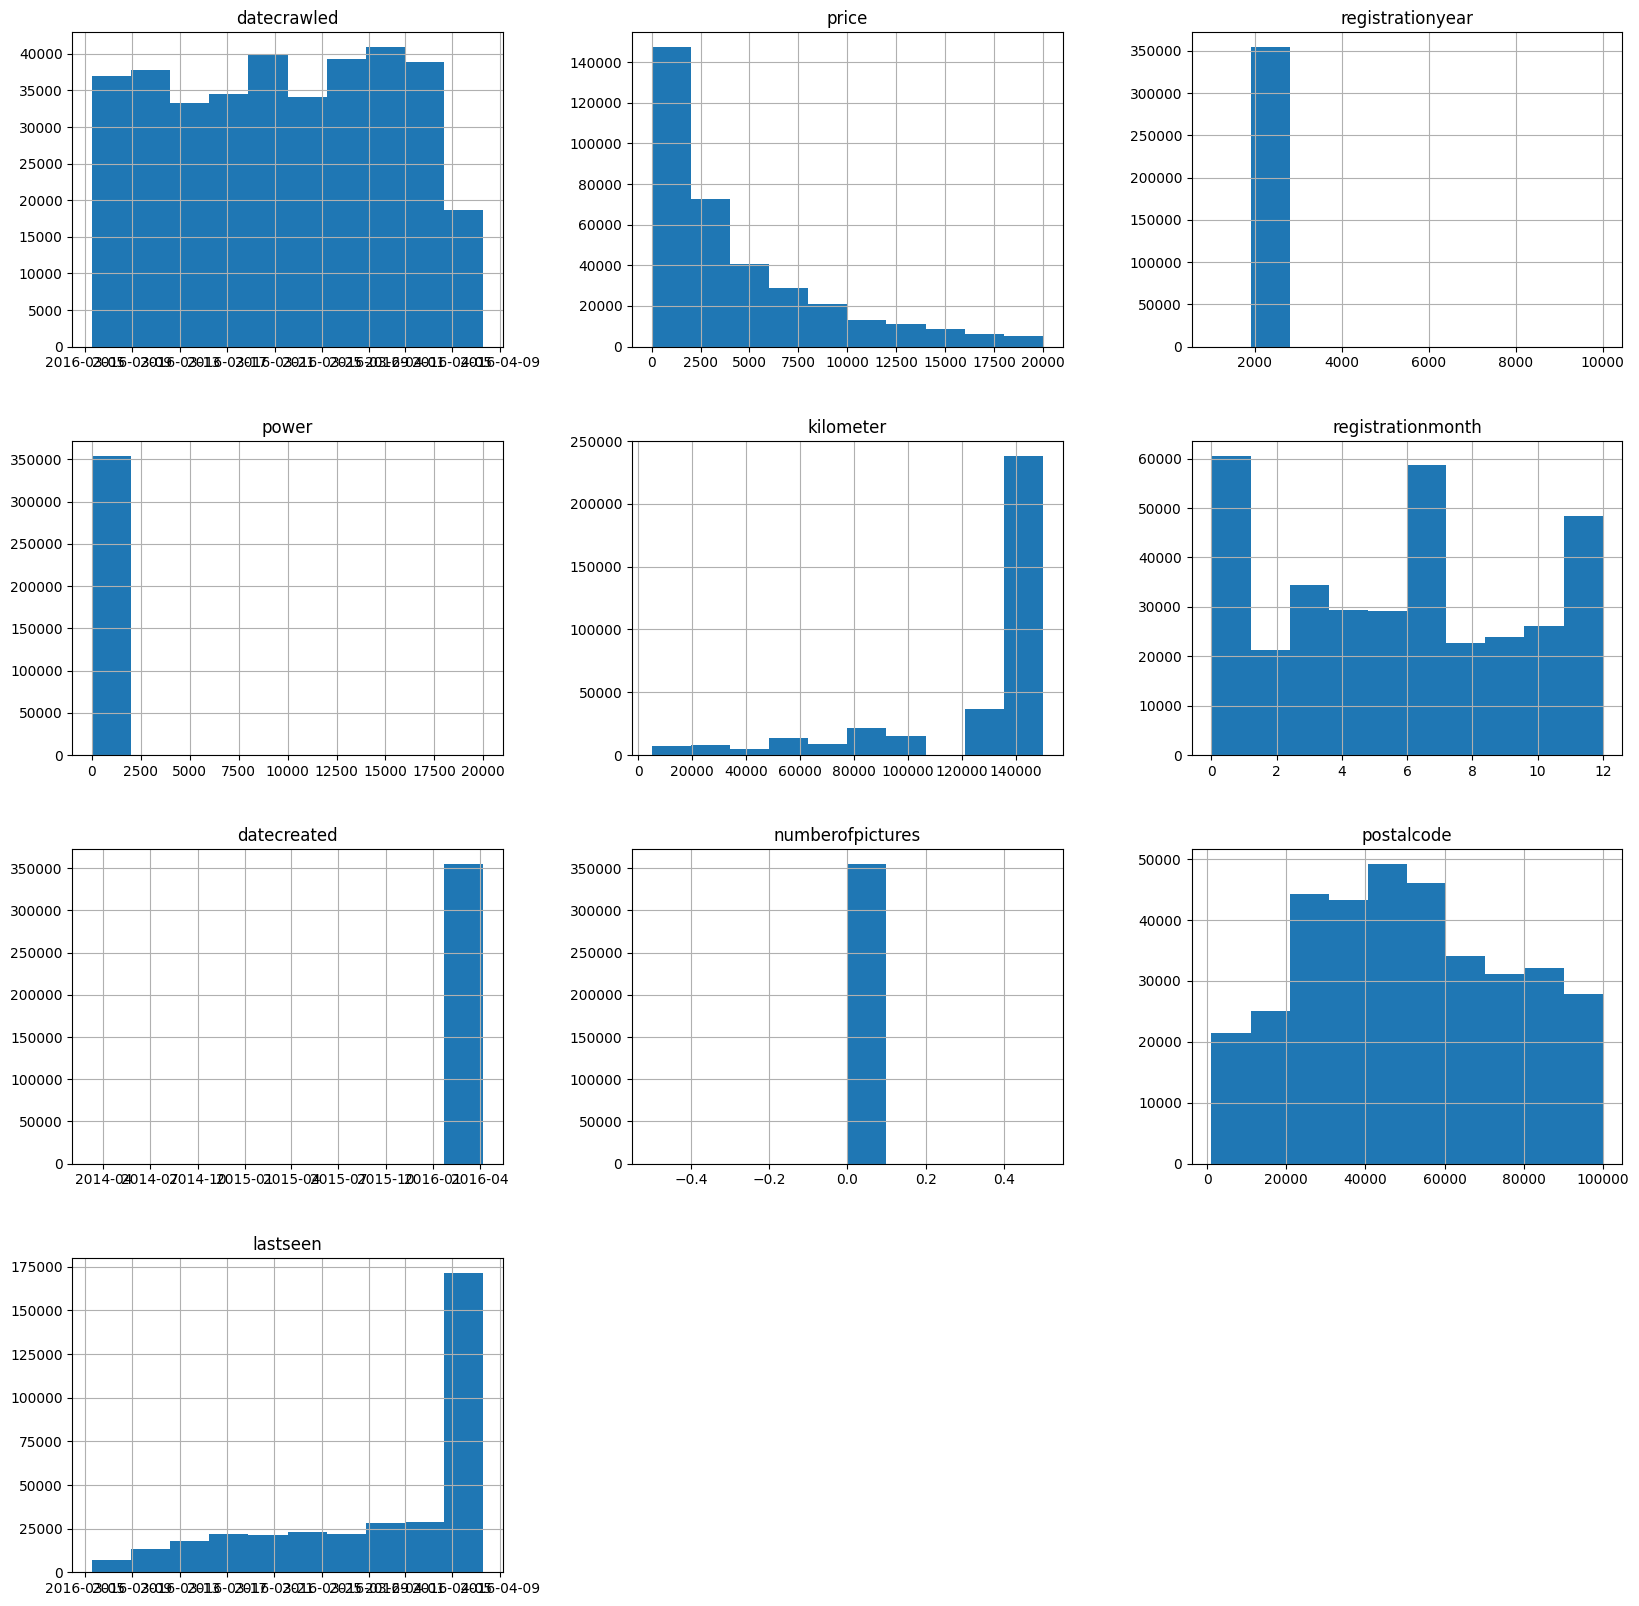

In [13]:
data.hist(figsize=(20, 20));

Как видно из гистограмм, в данных очень много выбросов. Нужно провести полную проверку данных.

**2. Предобработка данных.**

Обработаем целевой признак price, пропусков данных нет, но есть цена равная нулю, восстановить по среднему было бы некоректно, так как признак целевой и это напрямую повлияет на прогноз. Также думаю, что на рынке не много машин с ценой до 500 евро. Их тоже нужно удалить, так как возможно это ошибка заполнения данных.

In [14]:
print("Количество объявлений с ценой меньше 500 евро:",len(data.loc[data['price'] < 500]))

Количество объявлений с ценой меньше 500 евро: 36054


In [15]:
data = data.loc[data['price'] >= 500]

In [16]:
print("Количество объявлений с ценой меньше 500 евро:",len(data.loc[data['price'] < 500]))

Количество объявлений с ценой меньше 500 евро: 0


Все получилось.

Уберем из столбцов с датой время.

In [17]:
data['datecrawled'] = pd.to_datetime(data['datecrawled']).dt.normalize()

In [18]:
data['lastseen'] = pd.to_datetime(data['lastseen']).dt.normalize()

In [19]:
data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
1,2016-03-24,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06
5,2016-04-04,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06


Считаем количество явных дубликатов.

In [20]:
print('Количество явных дубликатов', data.duplicated().sum())

Количество явных дубликатов 6443


Удаляем явные дубликаты.

In [21]:
data = data.drop_duplicates()

In [22]:
print('Количество явных дубликатов', data.duplicated().sum())

Количество явных дубликатов 0


Явные дубликаты устранены.

Считаем количество пропущенных значений.

In [23]:
data.isna().sum()

datecrawled              0
price                    0
vehicletype          26864
registrationyear         0
gearbox              13116
power                    0
model                14554
kilometer                0
registrationmonth        0
fueltype             23139
brand                    0
repaired             53958
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

In [24]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
datecrawled,0.000000
price,0.000000
vehicletype,8.600000
registrationyear,0.000000
gearbox,4.200000
power,0.000000
model,4.700000
kilometer,0.000000
registrationmonth,0.000000
fueltype,7.400000


Пропуски в столбце модель мы не можем заменить на среднее или моду, поэтому строки с пропусками лучше удалить.

In [25]:
data['model'] = data['model'].fillna('unknown')

In [26]:
data['model'].unique()

array(['unknown', 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'other', 'c4', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo', '1er',
       'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'polo', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', 'escort', 'forester',
       'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo', 'focus',
       'tt', 'a6', 'jazz', 'slk', '7er', '80', '147', 'z_reihe',
       'sportage', 'sorento', 'ibiza', 'mustang', 'eos', 'touran', 'getz',
       'a3', 'ka', 'almera', 'megane', 'lupo', 'zafira', 'caddy', 'corsa',
       'mondeo', 'cordoba', 'colt', 'impreza', 'vectra', 'berlingo',
       'tiguan', 'i_reihe', 'espace', 'sharan', '6_reihe', 'panda', 'up',
       'seicento', 'ceed', '5_reihe', 'yeti', 'octavia', 'mii',
       'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio',
      

Посмотрим как изменилась карта с пропусками.

In [27]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
datecrawled,0.000000
price,0.000000
vehicletype,8.600000
registrationyear,0.000000
gearbox,4.200000
power,0.000000
model,0.000000
kilometer,0.000000
registrationmonth,0.000000
fueltype,7.400000


Посмотрим на пропуски в столбце vehicletype - тип кузова. Для начала выведем уникальные значения данного столбца.

In [28]:
data['vehicletype'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

Построим круговую диаграмму распределения значения столбца vehicletype.

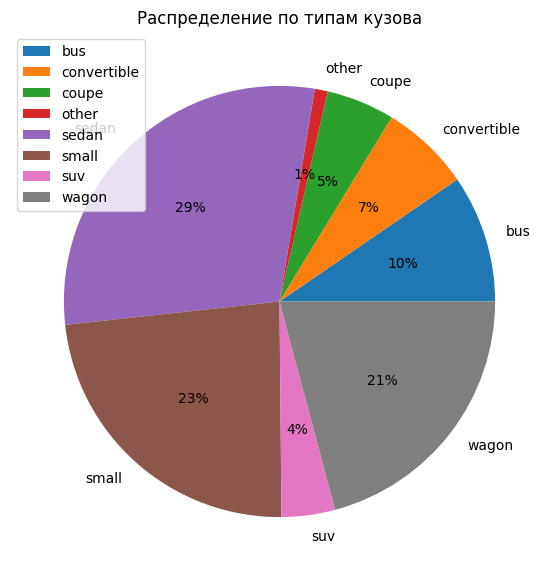

In [29]:
data.pivot_table(index='vehicletype',values='price',aggfunc='count') \
  .plot.pie(y='price', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Распределение по типам кузова")
plt.show()

У одной модели может быть несколько типов кузова. Тип кузова влияет на стоимость, т.к. в некоторых моделях больший спрос на определенный кузов. Думаю пропуски стоит тоже удалить.

In [30]:
data = data.dropna(subset=['vehicletype'])

In [31]:
data['repaired'].unique()

array(['yes', nan, 'no'], dtype=object)

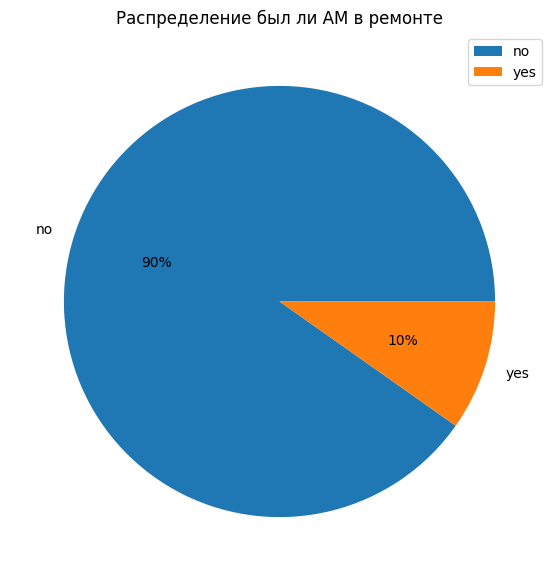

In [32]:
data.pivot_table(index='repaired',values='price',aggfunc='count') \
  .plot.pie(y='price', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Распределение был ли АМ в ремонте")
plt.show()

Столбец repaired указывает был ли автомобиль в ремонте. Думаю стоит предположить, что пропуски означают что АМ не был в ремонте. поэтому пропуски заменим на no.

In [33]:
data['repaired'] = data['repaired'].fillna('no') 

Столбец gearbox указывающий тип коробки передач, думаю стоит заполнять изходя из моды по модели. Не спорю, что одна и та же модель может быть как с механической коробкой передач, так и с автоматической. Но все же если использовать моду, то данные будут максимально приближенны к реальным.

In [34]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [35]:
data['gearbox'] = data['gearbox'].fillna(data
                                         .groupby('model')['gearbox']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

Такое же действие стоит провести со столбцом с типом топлива.

In [36]:
data['fueltype'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Понятия не имею, что за тип топлива 'manual', 'auto'. Есть предположени, что это ошибка заполнения данных и перепутано с коробкой передач. Оставим как есть, т.к. manual занимает 4 % от выборки.

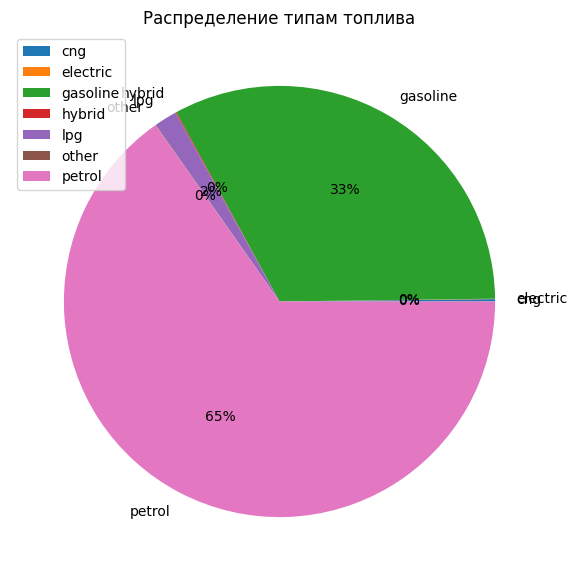

In [37]:
data.pivot_table(index='fueltype',values='price',aggfunc='count') \
  .plot.pie(y='price', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Распределение типам топлива")
plt.show()

In [38]:
data['fueltype'] = data['fueltype'].fillna(data
                                         .groupby('model')['gearbox']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

Проверим, что получилось в данных.

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285008 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        285008 non-null  datetime64[ns]
 1   price              285008 non-null  int64         
 2   vehicletype        285008 non-null  object        
 3   registrationyear   285008 non-null  int64         
 4   gearbox            285008 non-null  object        
 5   power              285008 non-null  int64         
 6   model              285008 non-null  object        
 7   kilometer          285008 non-null  int64         
 8   registrationmonth  285008 non-null  int64         
 9   fueltype           285008 non-null  object        
 10  brand              285008 non-null  object        
 11  repaired           285008 non-null  object        
 12  datecreated        285008 non-null  datetime64[ns]
 13  numberofpictures   285008 non-null  int64   

Осталось 82 % от исходных данных. Думаю этого достаточно, чтобы научить модель предсказывать стоимость АМ, тем более, что задача стоит научить модель максимально близко предсказывать цену АМ.

In [40]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
datecrawled,0.000000
price,0.000000
vehicletype,0.000000
registrationyear,0.000000
gearbox,0.000000
power,0.000000
model,0.000000
kilometer,0.000000
registrationmonth,0.000000
fueltype,0.000000


    В загрузке и подготовке данных было сделано следующее:
    - загружена таблица и предварительно осмотрены данные. В таблице 354369 строк и 16 столбцов. Пропуски в столбцах VehicleType, Gearbox, Model, FuelType, Repaired.
    - Удалены объявления с ценой менее 50 евро.
    - Убрано время из столбцов с датой.
    - Удалено 667 явных дубликатов.
    - Удалены пропуски в столбцах model и vehicletype. 
    - Заменены пропуски в столбце repaired на no.
    - Заменены пропуски в столбцах gearbox и fueltype на наиболее повторяющееся значение по модели АМ.

## Шаг 2. Исследовательский анализ данных.

In [41]:
data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
1,2016-03-24,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06
5,2016-04-04,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06


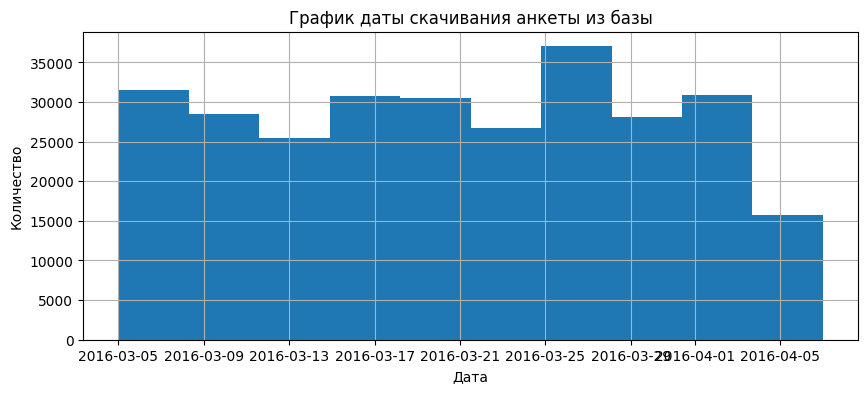

In [42]:
data['datecrawled'].hist()
plt.title("График даты скачивания анкеты из базы")
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

По столбцу дата скачивания можно сказать, что в среднем анкета скачивалась примерно одинаково есть незначительный всплеск скачиваний 25.03.2016 г. Данные предоставлены за период с 05.03.2016 по 05.04.2016 г., т.е. за 1 месяц.

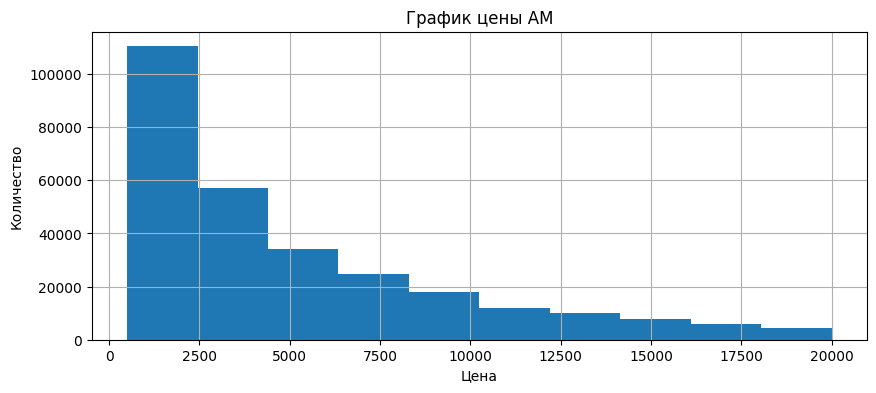

In [43]:
data['price'].hist()
plt.title("График цены АМ")
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

По цене наблюдается пик до 2500 евро. Думаю это легко объясняется, тем что АМ не новые. максимальная цена достигает 20000 евро.

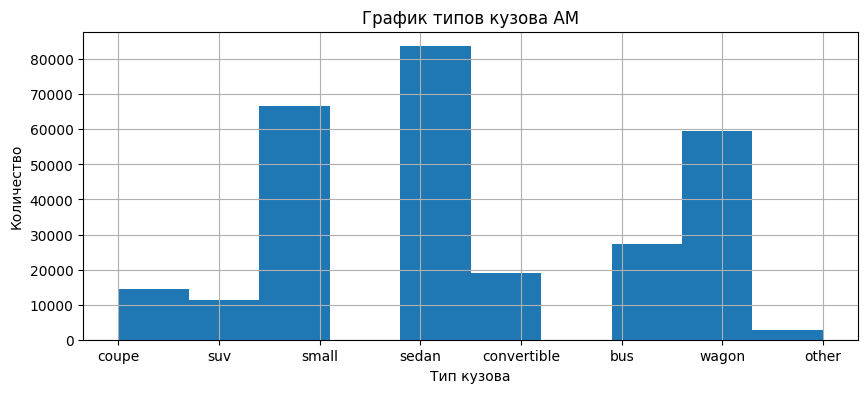

In [44]:
data['vehicletype'].hist()
plt.title("График типов кузова АМ")
plt.xlabel('Тип кузова')
plt.ylabel('Количество')
plt.show()

На рынке явно преобладают седаны и маленькие авто, на третьем месте хетчбеки. Ничего удивительно, в городе именно эти автомобили преобладают на дорогах.

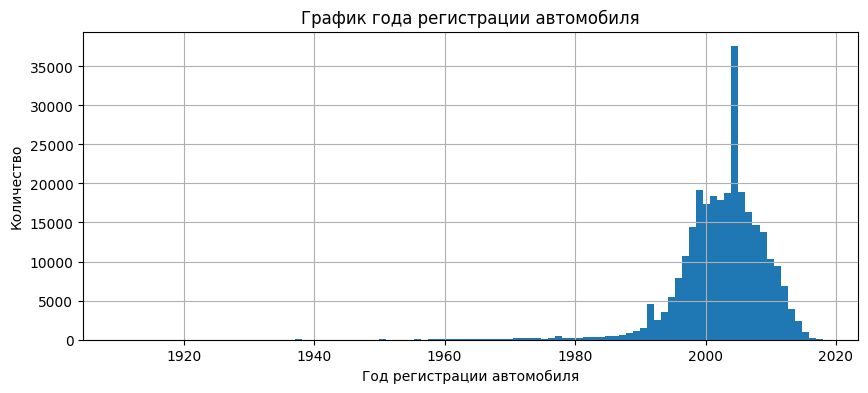

In [45]:
data['registrationyear'].hist(bins=100)
plt.title("График года регистрации автомобиля")
plt.xlabel('Год регистрации автомобиля')
plt.ylabel('Количество')
plt.show()

С учетом того, что данные по скачиванию анкеты с базы даны за 2016 год, то АМ не могут быть зарегистрированы позже 2016 года. Также нужно посмотреть на АМ выпущенные ранее 1960 г.

In [46]:
registration = (data.loc[(data['registrationyear'] > 2017) | (data['registrationyear'] < 1960)])
registration

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
1928,2016-03-25,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25,0,58135,2016-03-25
2273,2016-03-15,1800,convertible,1925,manual,0,unknown,5000,1,manual,sonstige_autos,no,2016-03-15,0,79288,2016-04-07
3333,2016-03-15,10500,sedan,1955,manual,30,other,60000,0,petrol,ford,no,2016-03-15,0,53498,2016-04-07
12993,2016-03-07,11000,other,1955,manual,40,unknown,50000,1,petrol,sonstige_autos,no,2016-03-07,0,59556,2016-03-14
13177,2016-03-19,2300,sedan,1958,manual,45,unknown,80000,1,petrol,sonstige_autos,no,2016-03-19,0,9600,2016-03-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348932,2016-04-01,11000,suv,1950,manual,0,other,5000,6,petrol,chevrolet,no,2016-04-01,0,79098,2016-04-05
351183,2016-03-27,17500,sedan,1954,manual,52,other,20000,7,petrol,citroen,no,2016-03-27,0,55270,2016-04-05
351299,2016-03-09,5500,bus,1956,manual,37,unknown,60000,4,petrol,sonstige_autos,no,2016-03-09,0,1900,2016-04-06
353531,2016-03-16,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,no,2016-03-16,0,23936,2016-03-30


Здесь наблюдается явная ошибка в заполнении данных, вероятно ошиблись в заполнении года, т.к fiat punto вышел в 1993 году а opel agila в 1991 г., и никак не в 1910 г. Поэтому эти данные удалим.

In [47]:
data = data.loc[(data['registrationyear'] <= 2016) & (data['registrationyear'] >= 1960)]

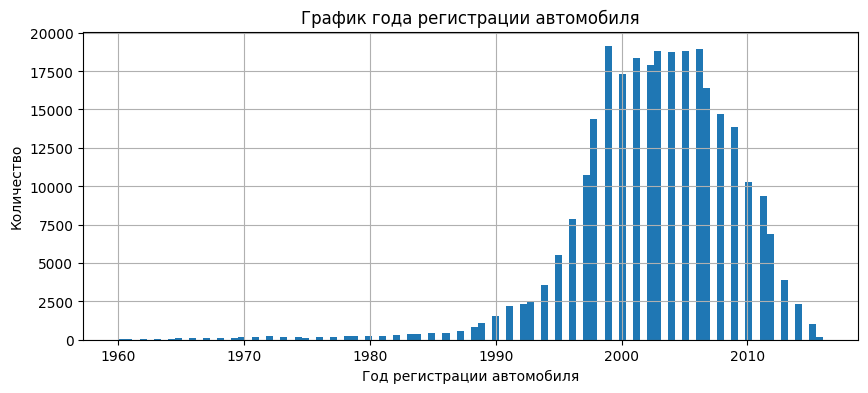

In [48]:
data['registrationyear'].hist(bins=100)
plt.title("График года регистрации автомобиля")
plt.xlabel('Год регистрации автомобиля')
plt.ylabel('Количество')
plt.show()

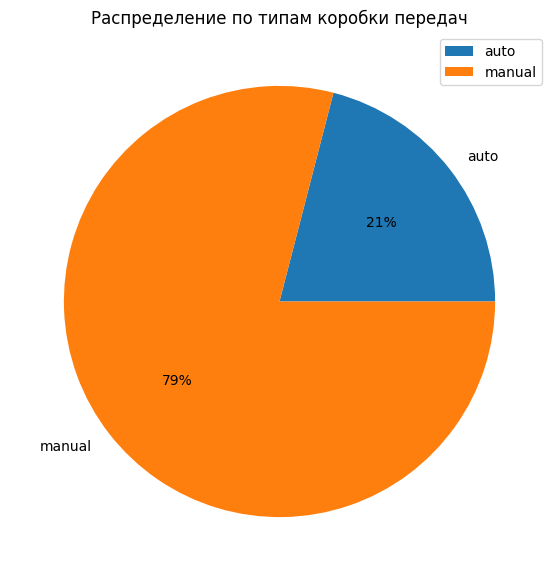

In [49]:
data.pivot_table(index='gearbox',values='price',aggfunc='count') \
  .plot.pie(y='price', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Распределение по типам коробки передач")
plt.show()

Преобладает ручная КПП, думаю данные российские, а как известно на нашем рынке больше автомобилей с ручной коробкой передач.

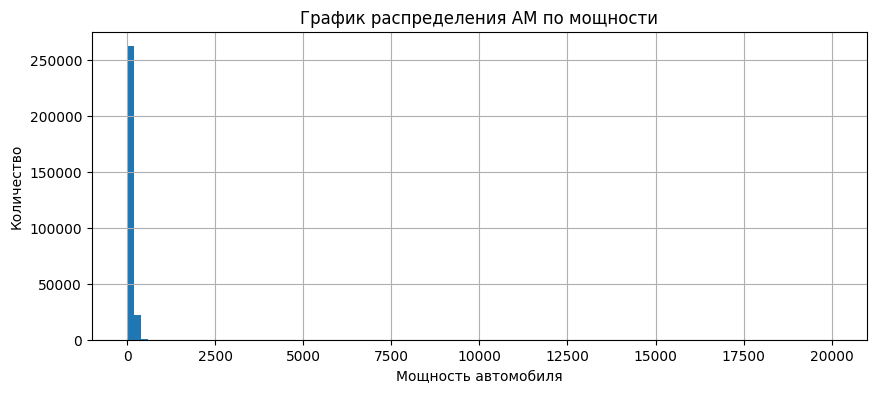

In [50]:
data['power'].hist(bins=100)
plt.title("График распределения АМ по мощности")
plt.xlabel('Мощность автомобиля')
plt.ylabel('Количество')
plt.show()

Есть автомобили с мощностью более 400 л.с. нужно посмотреть на эти автомобили для драг рейсинга.

In [51]:
power = data[data['power'] >= 400]
power

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
1816,2016-03-22,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,0,22043,2016-03-22
2781,2016-03-16,19500,suv,2004,auto,450,cayenne,125000,12,petrol,porsche,no,2016-03-16,0,38448,2016-04-01
3289,2016-03-10,16899,wagon,2003,auto,476,e_klasse,150000,9,petrol,mercedes_benz,no,2016-03-10,0,44319,2016-04-03
4060,2016-04-03,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03,0,60326,2016-04-07
4681,2016-03-25,13900,sedan,2006,auto,476,e_klasse,150000,5,petrol,mercedes_benz,no,2016-03-25,0,52078,2016-04-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352248,2016-03-22,15900,sedan,2001,manual,400,m_reihe,150000,8,petrol,bmw,no,2016-03-22,0,58840,2016-04-05
352322,2016-03-29,15999,wagon,2007,auto,435,other,150000,2,petrol,audi,no,2016-03-29,0,65510,2016-04-06
353633,2016-03-23,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,no,2016-03-23,0,45277,2016-03-27
354045,2016-03-22,20000,coupe,2006,auto,476,other,125000,7,petrol,mercedes_benz,no,2016-03-22,0,38118,2016-03-24


Здесь явная ошибка, не может маленький АМ иметь мощьность 7515 л.с., например volkswagen lupo. Эти данные также удалим.

In [52]:
data = data.loc[(data['power'] <= 400)]

Все автомобили с мощностью менее 4 л.с. тоже стоит удалить, т.к. минимальная мощность серийного автомобиля составляла всего 4,2 л.с https://fastmb.ru/autonews/autonews_mir/1367-samye-malomoschnye-avtomobili-top-10.html

In [53]:
data = data.loc[(data['power'] >= 4)]

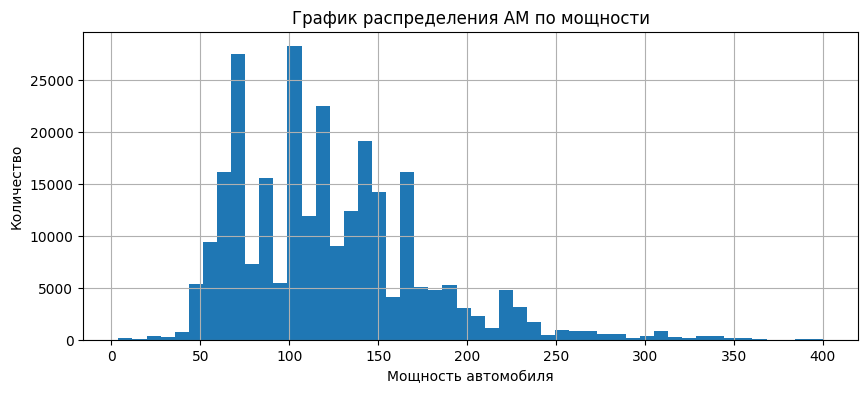

In [54]:
data['power'].hist(bins=50)
plt.title("График распределения АМ по мощности")
plt.xlabel('Мощность автомобиля')
plt.ylabel('Количество')
plt.show()

Наибольшее количество продаваемых автомобилей имеет мощность от 50 до 150 л.с. Думаю это как раз и характеризует весь рынок автомобилей.

In [55]:
data['model'].unique()

array(['unknown', 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'other', 'civic', 'transporter', 'punto', 'e_klasse',
       'kadett', 'one', 'fortwo', 'clio', '1er', 'b_klasse', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a1', 'focus', 'a4',
       'tt', 'astra', 'a6', 'jazz', 'polo', 'slk', '7er', 'combo', '80',
       '147', 'z_reihe', 'sorento', 'ibiza', 'mustang', 'eos', 'touran',
       'getz', 'insignia', 'ka', 'megane', 'a3', 'lupo', 'mondeo',
       'cordoba', 'colt', 'impreza', 'corsa', 'vectra', 'berlingo',
       'tiguan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe', 'ceed',
       'kangoo', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'fox', 'matiz', 'beetle', 'rio', 'touareg',
       'logan', 'caddy', 'spider', 'omega', 'cuore', 's_max', 'modus',
       'a2', 'galaxy', 'c3', 

Моделей автомобилей на рынке представлено довольно много, поэтому график строить не вижу смысла, он нечитабелен.

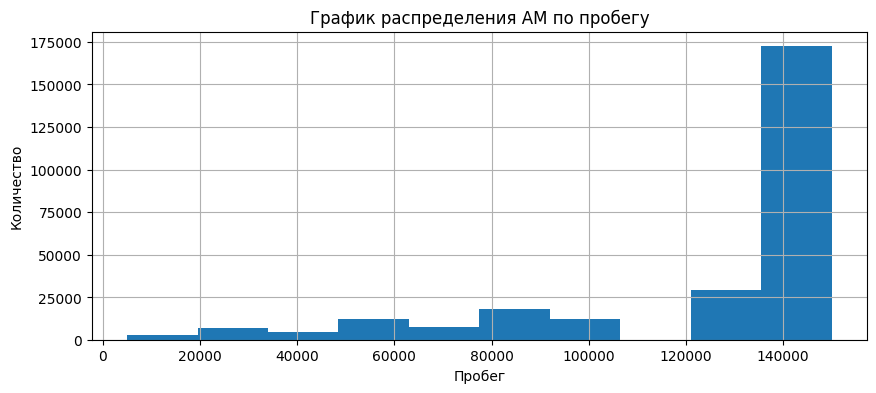

In [56]:
data['kilometer'].hist(bins=10)
plt.title("График распределения АМ по пробегу")
plt.xlabel('Пробег')
plt.ylabel('Количество')
plt.show()

Наибольшее количество продаваемых автомобилей на рынке имеют пробег в пределах 140000 км.

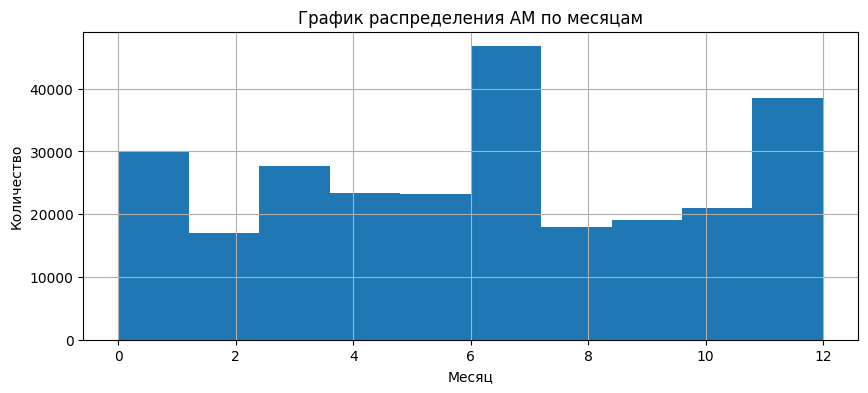

In [57]:
data['registrationmonth'].hist(bins=10)
plt.title("График распределения АМ по месяцам")
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.show()

Наибольшее количество зарегистрированных автомобилей было в июле.

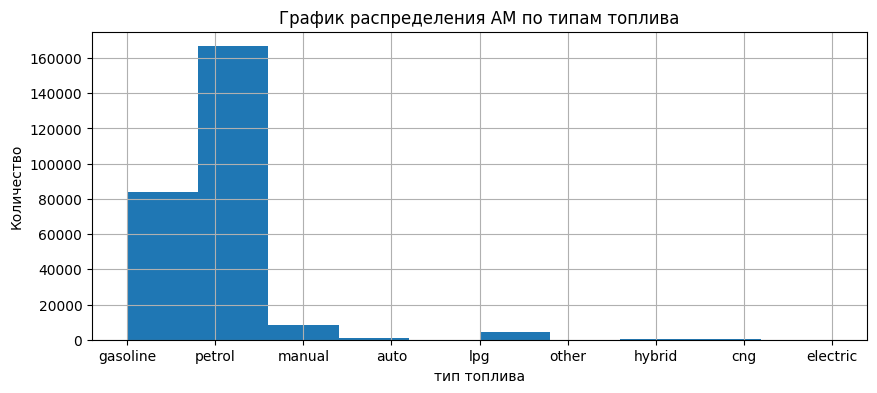

In [58]:
data['fueltype'].hist(bins=10)
plt.title("График распределения АМ по типам топлива")
plt.xlabel('тип топлива')
plt.ylabel('Количество')
plt.show()

Наибольшее количество автомобилей представленных на рынке заправляются бензином, на втором месте дизельное топливо. думаю на текущий момент эта тенденция наблюдается во всем мире. Исключение только Исландия.

In [59]:
data['brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'subaru', 'volvo', 'mitsubishi',
       'alfa_romeo', 'kia', 'seat', 'hyundai', 'suzuki', 'lancia',
       'citroen', 'toyota', 'chevrolet', 'dacia', 'sonstige_autos',
       'daihatsu', 'chrysler', 'jaguar', 'rover', 'porsche', 'saab',
       'daewoo', 'land_rover', 'trabant', 'lada'], dtype=object)

График распределения по брендам АМ тоже не имеет смысла строить, т.к. график становится нечитабельным.

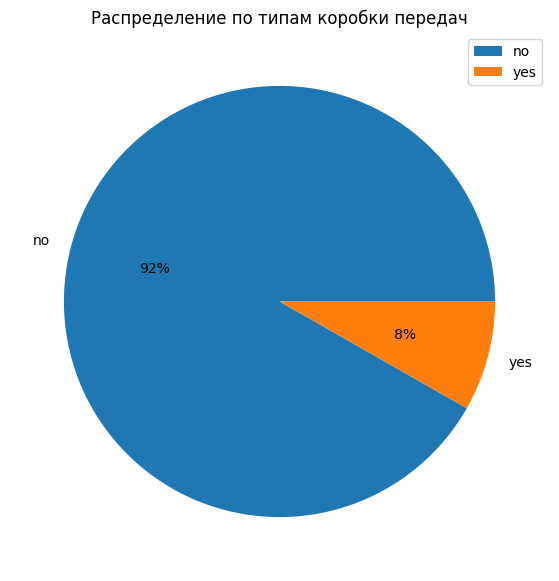

In [60]:
data.pivot_table(index='repaired',values='price',aggfunc='count') \
  .plot.pie(y='price', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Распределение по типам коробки передач")
plt.show()

10 % от общего числа представленных автомобилей на рынке восстановлены после аварий. Не очень хорошая статистика, причем это только официально. Шанс попасть на восстановленный после аварии автомобиль составляй 1 к 10.

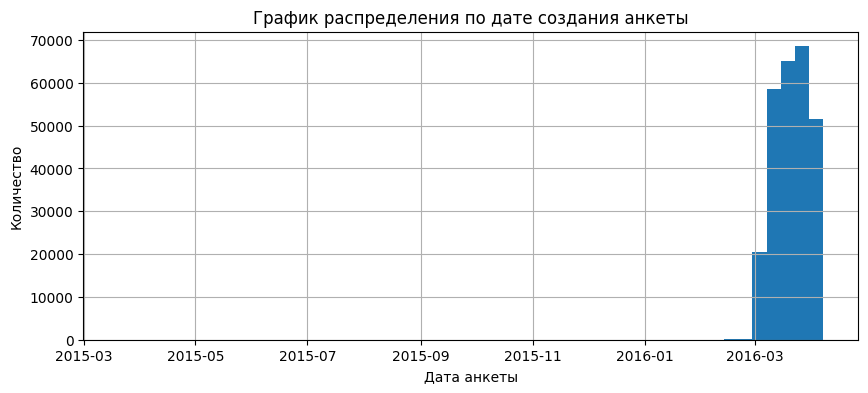

In [61]:
data['datecreated'].hist(bins=50)
plt.title("График распределения по дате создания анкеты")
plt.xlabel('Дата анкеты')
plt.ylabel('Количество')
plt.show()

Имеются анкеты созданные до 2016 года. Но в данном случае это никак не влияет на целевой признак, поэтому оставим как есть.

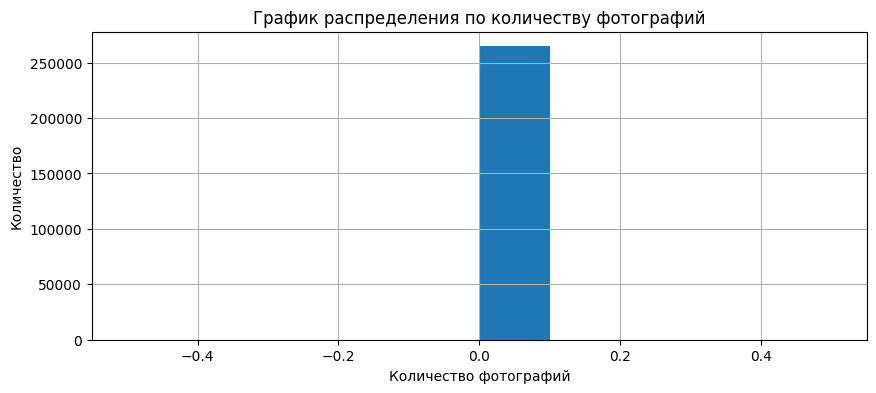

In [62]:
data['numberofpictures'].hist()
plt.title("График распределения по количеству фотографий")
plt.xlabel('Количество фотографий')
plt.ylabel('Количество')
plt.show()

Фотографий нет, думаю этот столбец вообще нужно удалить.

In [63]:
data = data.drop(['numberofpictures'], axis=1)

In [64]:
data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,postalcode,lastseen
1,2016-03-24,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06
5,2016-04-04,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06


In [65]:
data['postalcode'].unique()

array([66954, 90480, 91074, ..., 86751, 89344, 95691], dtype=int64)

Почтовый индекс продавца думаю не имеет значения. Поэтому столбец удалим.

In [66]:
data = data.drop(['postalcode'], axis=1)

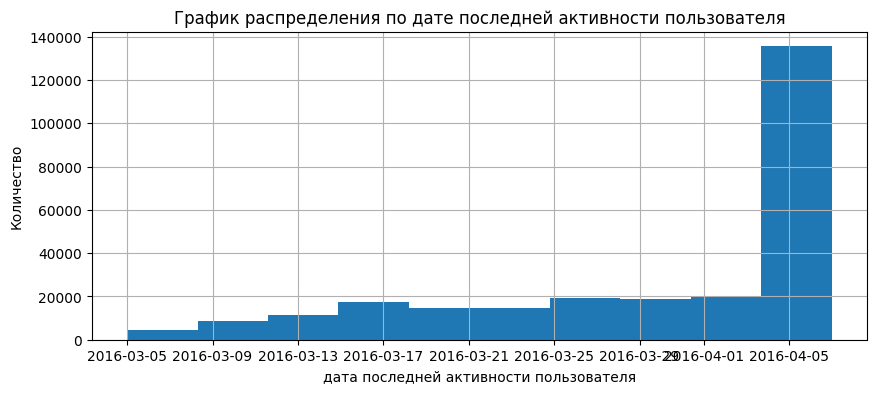

In [67]:
data['lastseen'].hist()
plt.title("График распределения по дате последней активности пользователя")
plt.xlabel('дата последней активности пользователя')
plt.ylabel('Количество')
plt.show()

Для прогнозирования цены нам также не нужны столбцы 'datecrawled', 'lastseen', 'datecreated'. поэтому эти столбцы удалим.

In [68]:
data = data.drop(['datecrawled', 'lastseen', 'datecreated'], axis=1)

Удалим столбец registrationmonth, т.к. для покупателя неважно в каком месяце приобретен автомобиль.

In [69]:
data = data.drop(['registrationmonth'], axis=1)

Сделаем сброс индекса.

In [70]:
data = data.reset_index(drop=True)

Повторно проверим таблицу на наличие явных дубликатов.

In [71]:
print('Количество явных дубликатов', data.duplicated().sum())

Количество явных дубликатов 37547


Удалим новые дубликаты.

In [72]:
data = data.drop_duplicates()

In [73]:
data = data.reset_index(drop=True)

In [74]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Посмотрим зависимость распределения целевого признака от других параметром таблицы.

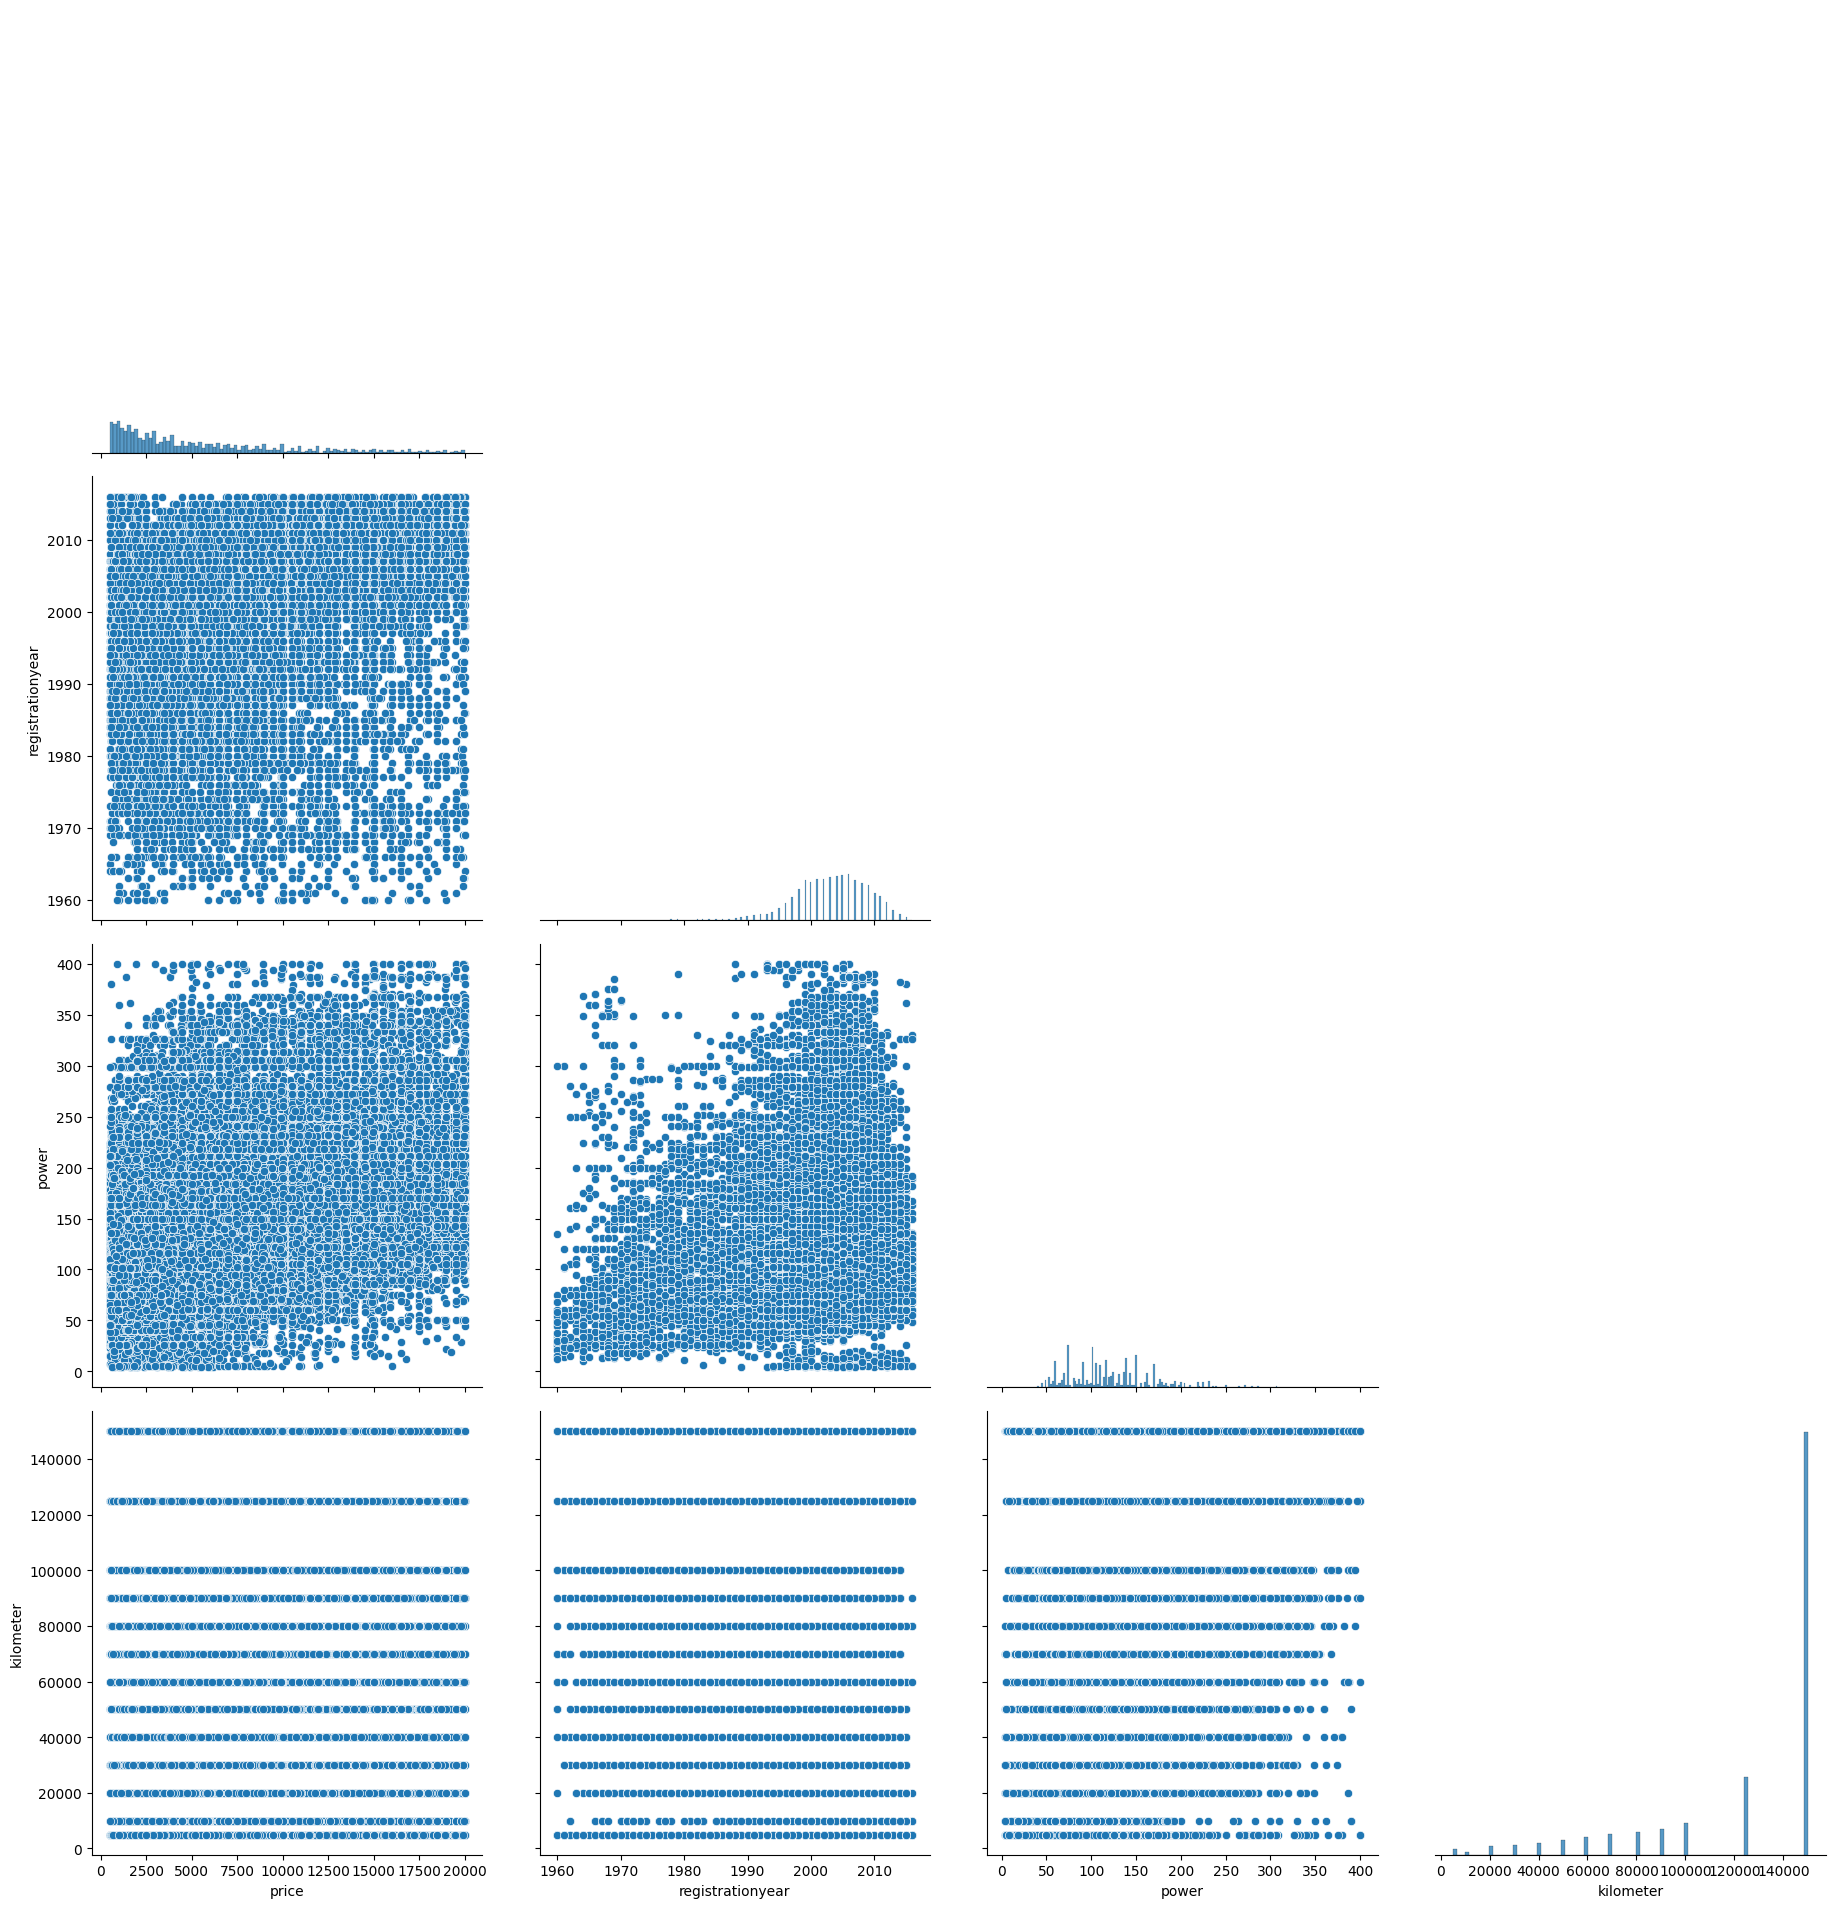

In [75]:
g = sns.pairplot(data, corner=True)
g.fig.set_size_inches(20, 20)

In [76]:
data.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'repaired'],
      dtype='object')

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227094 entries, 0 to 227093
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             227094 non-null  int64 
 1   vehicletype       227094 non-null  object
 2   registrationyear  227094 non-null  int64 
 3   gearbox           227094 non-null  object
 4   power             227094 non-null  int64 
 5   model             227094 non-null  object
 6   kilometer         227094 non-null  int64 
 7   fueltype          227094 non-null  object
 8   brand             227094 non-null  object
 9   repaired          227094 non-null  object
dtypes: int64(4), object(6)
memory usage: 17.3+ MB


In [78]:
data.describe()

,price,registrationyear,power,kilometer
count,227094.000000,227094.000000,227094.000000,227094.000000
mean,5346.045149,2002.983857,124.414916,126032.501960
std,4680.119310,6.309799,53.022965,37850.804933
min,500.000000,1960.000000,4.000000,5000.000000
25%,1699.000000,1999.000000,86.000000,100000.000000
50%,3700.000000,2004.000000,116.000000,150000.000000
75%,7700.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,400.000000,150000.000000


Данные выглядят более правдоподобно, остался только месяц регистрации 0, но в данном случае не могу сделать предположение в какой месяц отнести, поэтому эти данные оставляем как есть.

    В исследовательском анализе данных было проведено следующее:
    - По столбцу дата скачивания можно сказать, что в среднем анкета скачивалась примерно одинаково есть незначительный всплеск скачиваний 25.03.2016 г. Данные предоставлены за период с 05.03.2016 по 05.04.2016 г., т.е. за 1 месяц.
    - По цене наблюдается пик до 2500 евро. Думаю это легко объясняется, тем что АМ не новые. максимальная цена достигает 20000 евро.
    - На рынке явно преобладают седаны и маленькие авто, на третьем месте хетчбеки. Ничего удивительно, в городе именно эти автомобили преобладают на дорогах.
    - С учетом того, что данные по скачиванию анкеты с базы даны за 2016 год, то АМ не могут быть зарегистрированы позже 2016 года. Также нужно посмотреть на АМ выпущенные ранее 1916 г. Здесь явная ошибка, не может маленький АМ иметь мощность 7515 л.с., например volkswagen lupo. Эти данные также удалим.
    - Наибольшее количество продаваемых автомобилей имеет мощность от 50 до 150 л.с. Думаю это как раз и характеризует весь рынок автомобилей.
    - Моделей автомобилей на рынке представлено довольно много, поэтому график строить не вижу смысла, он нечитабелен.
    - Наибольшее количество продаваемых автомобилей на рынке имеют пробег в пределах 140000 км.
    - Наибольшее количество зарегистрированных автомобилей было в июле.
    - Наибольшее количество автомобилей представленных на рынке заправляются бензином, на втором месте дизельное топливо. думаю на текущий момент эта тенденция наблюдается во всем мире. Исключение только Исландия.
    - График распределения по брендам АМ тоже не имеет смысла строить, т.к. график становится нечитабельным.
    - 10 % от общего числа представленных автомобилей на рынке восстановлены после аварий. Не очень хорошая статистика, причем это только официально. Шанс попасть на восстановленный после аварии автомобиль составляй 1 к 10.
    - Имеются анкеты созданные до 2016 года. Но в данном случае это никак не влияет на целевой признак, поэтому оставим как есть.
    - Фотографий нет, думаю этот столбец вообще нужно удалить.
    - Почтовый индекс продавца думаю не имеет значения. Поэтому столбец удалим. Этот столбец имел бы значение, если бы был представлен регионом. А так у каждого населенного пункта свой почтовый индекс, а в городе вообще в одном районе несколько индексов.
    - Для прогнозирования цены нам также не нужны столбцы 'datecrawled', 'lastseen', 'datecreated'. поэтому эти столбцы удалим

## Шаг 3. Подготовка данных для обучения моделей.

Выделяю признаки и целевой признак 

In [79]:
X = data.drop('price', axis=1)
y = data['price']

Разделяю выборку на тренировочную и тестовую. Соотношение 80:20

In [80]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=RANDOM_STATE
)

Проверяю размерность.

In [81]:
X_train.shape, X_test.shape

((181675, 9), (45419, 9))

Кодирум данные с помощью OneHotEncoder и StandardScaler

In [82]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [83]:
cat_col_names = ['gearbox', 'repaired', 'vehicletype', 'registrationyear', 'kilometer', 'fueltype']
cat_col_names_oe = ['model', 'brand']
num_col_names = ['power']

In [84]:
#One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='error')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names()

ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

#OrdinalEncoding
X_train_oe = ordinal.fit_transform(X_train[cat_col_names_oe])
X_test_oe = ordinal.fit_transform(X_test[cat_col_names_oe])

#ordinal_col_names = ordinal.get_feature_names()

#StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

#Соединим данные в единый датафрейм
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names, index=X_test.index)

X_train_oe = pd.DataFrame(X_train_oe, columns=cat_col_names_oe, index=X_train.index)
X_test_oe = pd.DataFrame(X_test_oe, columns=cat_col_names_oe, index=X_test.index)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names, index=X_test.index)

X_train = pd.concat([X_train_ohe, X_train_oe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_oe, X_test_scaled], axis=1)

In [85]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45419 entries, 61837 to 175806
Data columns (total 88 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   x0_manual       45419 non-null  float64
 1   x1_yes          45419 non-null  float64
 2   x2_convertible  45419 non-null  float64
 3   x2_coupe        45419 non-null  float64
 4   x2_other        45419 non-null  float64
 5   x2_sedan        45419 non-null  float64
 6   x2_small        45419 non-null  float64
 7   x2_suv          45419 non-null  float64
 8   x2_wagon        45419 non-null  float64
 9   x3_1961         45419 non-null  float64
 10  x3_1962         45419 non-null  float64
 11  x3_1963         45419 non-null  float64
 12  x3_1964         45419 non-null  float64
 13  x3_1965         45419 non-null  float64
 14  x3_1966         45419 non-null  float64
 15  x3_1967         45419 non-null  float64
 16  x3_1968         45419 non-null  float64
 17  x3_1969         45419 non-

In [86]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181675 entries, 101250 to 121958
Data columns (total 88 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   x0_manual       181675 non-null  float64
 1   x1_yes          181675 non-null  float64
 2   x2_convertible  181675 non-null  float64
 3   x2_coupe        181675 non-null  float64
 4   x2_other        181675 non-null  float64
 5   x2_sedan        181675 non-null  float64
 6   x2_small        181675 non-null  float64
 7   x2_suv          181675 non-null  float64
 8   x2_wagon        181675 non-null  float64
 9   x3_1961         181675 non-null  float64
 10  x3_1962         181675 non-null  float64
 11  x3_1963         181675 non-null  float64
 12  x3_1964         181675 non-null  float64
 13  x3_1965         181675 non-null  float64
 14  x3_1966         181675 non-null  float64
 15  x3_1967         181675 non-null  float64
 16  x3_1968         181675 non-null  float64
 17  x3_19

Данные закодированы.

## Шаг 4. Обучение моделей.

**Linear Regression**

Обучение модели.

In [87]:
model_lr1 = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
parameters_lr = {}

In [88]:
model_lr = GridSearchCV(model_lr1, parameters_lr, scoring='neg_mean_squared_error')
model_lr.fit(X_train, y_train)
start = time()
model_lr.best_estimator_.fit(X_train, y_train)
end = time()
time_lr = (end-start)

mse_model_lr = ((model_lr.best_score_)*-1)**0.5
print("Оптимальная комбинация гиперпараметров LinearRegression:", model_lr.best_params_)
print()
print("RSME модели LinearRegression:", mse_model_lr)

start1 = time()
preds_model_lr = model_lr.best_estimator_.predict(X_train)

end1 = time()
time_lr_pred = (end1-start1)

Оптимальная комбинация гиперпараметров LinearRegression: {}

RSME модели LinearRegression: 2330.699713549562


**Регрессия DecisionTreeRegressor**

Обучение модели.

In [89]:
%%time

model_tr1 = DecisionTreeRegressor(
                              max_depth=8, 
                              random_state=RANDOM_STATE) 

parameters_tr = {"max_depth": [None,3,5],
      "min_samples_split": np.arange(2, 6, 12),
      "min_samples_leaf" : np.arange(1, 5, 10)}

model_tr = GridSearchCV(model_tr1, parameters_tr, scoring='neg_mean_squared_error')
model_tr.fit(X_train, y_train)

start = time()
model_tr.best_estimator_.fit(X_train, y_train)
end = time()
time_tr = (end-start)

mse_model_tr = ((model_tr.best_score_)*-1)**0.5
print("Оптимальная комбинация гиперпараметров DecisionTreeRegressor:", model_tr.best_params_)
print()
print("RSME модели DecisionTreeRegressor:", mse_model_tr)

start1 = time()
preds_model_lr = model_lr.best_estimator_.predict(X_train)

end1 = time()
time_tr_pred = (end1-start1)

Оптимальная комбинация гиперпараметров DecisionTreeRegressor: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

RSME модели DecisionTreeRegressor: 2090.4337527612347
CPU times: total: 25.7 s
Wall time: 25.8 s


**Регрессия LGBMRegressor**

Обучение модели.

In [90]:
%%time

model_lgbm_1 = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=100, 
                      random_state=RANDOM_STATE)
parameters_lgbm = {
      'learning_rate': [0.1, 0.01],
      'n_estimators': [50, 100, 150],
      'max_depth': [4, 6],
      'colsample_bytree': [0.7, 0.8],
      'subsample': [0.7, 0.8],
      'min_child_samples': [1, 5]}

model_lgbm = GridSearchCV(model_lgbm_1, parameters_lgbm, scoring='neg_mean_squared_error')
model_lgbm.fit(X_train, y_train)

start = time()
model_lgbm.best_estimator_.fit(X_train, y_train)
end = time()
time_lgbm = (end-start)

mse_model_lgbm = ((model_lgbm.best_score_)*-1)**0.5
print("Оптимальная комбинация гиперпараметров LGBMRegressor:", model_lgbm.best_params_)
print()
print("RSME модели LGBMRegressor:", mse_model_lgbm)

start1 = time()
preds_model_lgbm = model_lgbm.best_estimator_.predict(X_train)

end1 = time()
time_lgbm_pred = (end1-start1)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 145340, number of used features: 88
[LightGBM] [Info] Start training from score 5345.935785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 145340, number of used features: 88
[LightGBM] [Info] Start training from score 5346.257568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004765 s

**Регрессия CatBoostRegressor**

Обучение модели.

In [91]:
%%time

model_cat1 = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

model_cat = GridSearchCV(model_cat1, parameters, scoring='neg_mean_squared_error')
model_cat.fit(X_train, y_train)

start = time()
model_cat.best_estimator_.fit(X_train, y_train)
end = time()
time_cat = (end-start)

mse_model_cat = ((model_cat.best_score_)*-1)**0.5
print("Оптимальная комбинация гиперпараметров CatBoostRegressor:", model_cat.best_params_)
print()
print("RSME модели CatBoostRegressor:", mse_model_cat)

start1 = time()
preds_model_cat = model_cat.best_estimator_.predict(X_train)

end1 = time()
time_cat_pred = (end1-start1)

Оптимальная комбинация гиперпараметров CatBoostRegressor: {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

RSME модели CatBoostRegressor: 1646.0813995634514
CPU times: total: 12min 46s
Wall time: 3min 55s


**Регрессия DummyRegressor**

In [92]:
%%time

dummy_regr1 = DummyRegressor(strategy="mean")
parameters = {}
dummy_regr = GridSearchCV(dummy_regr1, parameters, scoring='neg_mean_squared_error')
dummy_regr.fit(X_train, y_train)

start = time()
dummy_regr.best_estimator_.fit(X_train, y_train)
end = time()
time_dummy = (end-start)

mse_model_dummy = ((dummy_regr.best_score_)*-1)**0.5
print("Оптимальная комбинация гиперпараметров DummyRegressor:", dummy_regr.best_params_)
print()
print("RSME модели DummyRegressor:", mse_model_dummy)

start1 = time()
preds_model_cat = dummy_regr.best_estimator_.predict(X_train)

end1 = time()
time_dummy_pred = (end1-start1)

Оптимальная комбинация гиперпараметров DummyRegressor: {}

RSME модели DummyRegressor: 4682.750610314289
CPU times: total: 297 ms
Wall time: 298 ms


Время, я так понимаю, значение относительное и зависит от мощности ПК. Оговорюсь сразу, у меня компьютер был собран в январе 2013 года. Технические характеристики могу приложить. Над приобретением нового задумаюсь после окончания.

В обучении моделей было проведено следующее:

    - Построена модель Linear Regression. Время обучения 852 милисекунд, время предсказания 34 милисекунды. RMSE для линейной модели на валидационной выборке: 2326
    - Построена модель DecisionTreeRegresso. Время обучения 3,87 секунд, время предсказания 36 милисекунд. RMSE для DecisionTreeRegresso модели на валидационной выборке: 2080
    - Построена модель LGBMRegressor. Время обучения 1,12 секунд, время предсказания 503 милисекунд. RMSE для LGBMRegressor модели на валидационной выборке: 1812
    - Построена модель CatBoostRegressor. Время обучения 18 секунды, время предсказания 121 милисекунда. RMSE для CatBoostRegressor модели на валидационной выборке: 1644
    - В качестве сравнения построена модель DummyRegressor. Время обучения 0 милисекунд, время предсказания 0 милисекунд. RMSE для CatBoostRegressor модели на валидационной выборке: 4682
    - Лучшими моделями являются LGBMRegressor и CatBoostRegressor.

## Шаг 5. Анализ времени обучения, времени предсказания и качества моделей.

In [93]:
df = [[time_lr, time_lr_pred, mse_model_lr],
        [time_tr, time_tr_pred, mse_model_tr],
        [time_lgbm, time_lgbm_pred, mse_model_lgbm],
        [time_cat, time_cat_pred, mse_model_cat],
        [time_dummy, time_dummy_pred, mse_model_dummy]]
model = ["Linear Regression", "DecisionTreeRegressor", "LGBMRegressor", "CatBoostRegressor", "DummyRegressor"]

In [94]:
pd.DataFrame(data=df, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
Linear Regression,1.342057,0.027981,2330.699714
DecisionTreeRegressor,3.317665,0.027983,2090.433753
LGBMRegressor,1.191161,0.607572,1803.093511
CatBoostRegressor,15.610160,0.092936,1646.081400
DummyRegressor,0.000000,0.000999,4682.750610


Наилучшей моделью по среднеквадратичной ошибке (RSME) является CatBoostRegresso со значением 1614. в то же время она является наиболее медленной по времени обучения с показателем 18 секунд. Второй по показателю RSME 1812 является модель LGBMRegressor.

## Шаг 6. Выбор лучшей модели и проверка качества на тестовой выборке.

Сравним модель DecisionTreeRegresso и DummyRegressor для проверки актуальности работы модели.

**Регрессия CatBoostRegressor**

In [95]:
%%time
start = time()
cat_predict1 = model_cat.predict(X_test)
end = time()
time_cat_pred1 = (end-start)

CPU times: total: 62.5 ms
Wall time: 27 ms


In [96]:
mse_model_cat1 = mean_squared_error(y_test, cat_predict1) ** 0.5
print("RMSE для CatBoostRegressor модели на тестовой выборке:", round((mse_model_cat1), 2))

RMSE для CatBoostRegressor модели на тестовой выборке: 1705.73


In [97]:
# посчитаем ошибки
mae_cat = mean_absolute_error(cat_predict1, y_test)
mse_cat = mean_squared_error(cat_predict1, y_test)
rmse_cat = mean_squared_error(cat_predict1, y_test, squared=False) 
r2_cat = r2_score(y_test, cat_predict1)

# выведем ошибки
print(f"R2 CatBoostRegressor = {r2_cat:.2f}")
print(f"RSME = {rmse_cat:.0f}")
print(f'MSE = {mse_cat:.0f}')
print(f'MAE = {mae_cat:.0f}')
#Сравним первые строки прогноза с реальным значением
print('Прогнозируемое значение (первая строка) = ', cat_predict1[0], 'Реальное значение (первая строка) = ', y_test.reset_index(drop = True)[0])

R2 CatBoostRegressor = 0.87
RSME = 1706
MSE = 2909499
MAE = 1096
Прогнозируемое значение (первая строка) =  8675.18781069697 Реальное значение (первая строка) =  8700


**Регрессия DummyRegressor**

In [98]:
%%time
start = time()
preds_model_dummy1 = dummy_regr.predict(X_test)
end = time()
time_dummy_pred1 = (end-start)

CPU times: total: 0 ns
Wall time: 0 ns


In [99]:
mse_model_dummy1 = mean_squared_error(y_test, preds_model_dummy1) ** 0.5
print("RMSE для DummyRegressor модели на тестовой выборке:", round((mse_model_dummy), 2))

RMSE для DummyRegressor модели на тестовой выборке: 4682.75


In [100]:
# посчитаем ошибки
mae_dummy = mean_absolute_error(preds_model_dummy1, y_test)
mse_dummy = mean_squared_error(preds_model_dummy1, y_test)
rmse_dummy = mean_squared_error(preds_model_dummy1, y_test, squared=False) 
r2_dummy = r2_score(y_test, preds_model_dummy1)

# выведем ошибки
print(f"R2 DummyRegressor = {r2_dummy:.2f}")
print(f"RSME = {rmse_dummy:.0f}")
print(f'MSE = {mse_dummy:.0f}')
print(f'MAE = {mae_dummy:.0f}')
#Сравним первые строки прогноза с реальным значением
print('Прогнозируемое значение (первая строка) = ', preds_model_dummy1[0], 'Реальное значение (первая строка) = ', y_test.reset_index(drop = True)[0])

R2 DummyRegressor = -0.00
RSME = 4670
MSE = 21805679
MAE = 3734
Прогнозируемое значение (первая строка) =  5351.0673125086005 Реальное значение (первая строка) =  8700


In [101]:
df1 = [[time_cat, time_cat_pred1, mae_cat, mse_cat, rmse_cat, r2_cat],
       [time_dummy, time_dummy_pred1, mae_dummy, mse_dummy, rmse_dummy, r2_dummy]]
model1 = ["CatBoostRegressor", "DummyRegressor"]

In [102]:
pd.DataFrame(data=df1, index=model1, columns=["fit_time", "predict_time", "MAE", "MSE", "RMSE", "R2"])

,fit_time,predict_time,MAE,MSE,RMSE,R2
CatBoostRegressor,15.61016,0.026983,1096.107929,2.909499e+06,1705.725489,0.866568
DummyRegressor,0.00000,0.000000,3733.527500,2.180568e+07,4669.655179,-0.000029


    Лучшей моделью является CatBoostRegressor следующими показателями:
    - R2 CatBoostRegressor = 0.86
    - RSME = 1746
    - MSE = 3048954
    - MAE = 1121
    - Прогнозируемое значение (первая строка) =  3924.2261756382673 Реальное значение (первая строка) =  2350

Время обучения и показатели ошибок лучше у CatBoostRegressor.

## Шаг 7. Общий вывод.

**После проведения анализа данных и построения моделей можно сделать следующие выводы:**
1. В загрузке и подготовке данных было сделано следующее:
    - загружена таблица и предварительно осмотрены данные. В таблице 354369 строк и 16 столбцов. Пропуски в столбцах VehicleType, Gearbox, Model, FuelType, Repaired.
    - Удалены объявления с ценой менее 500 евро.
    - Убрано время из столбцов с датой.
    - Удалено 667 явных дубликатов.
    - Удалены пропуски в столбце vehicletype. 
    - Произведена замена на заглушку пропусков в столбце model. 
    - Заменены пропуски в столбце repaired на no.
    - Заменены пропуски в столбцах gearbox и fueltype на наиболее повторяющееся значение по модели АМ.
2. В исследовательском анализе данных было проведено следующее:
    - По столбцу дата скачивания можно сказать, что в среднем анкета скачивалась примерно одинаково есть незначительный всплеск скачиваний 25.03.2016 г. Данные предоставлены за период с 05.03.2016 по 05.04.2016 г., т.е. за 1 месяц.
    - По цене наблюдается пик до 2500 евро. Думаю это легко объясняется, тем что АМ не новые. максимальная цена достигает 20000 евро.
    - На рынке явно преобладают седаны и маленькие авто, на третьем месте хетчбеки. Ничего удивительно, в городе именно эти автомобили преобладают на дорогах.
    - С учетом того, что данные по скачиванию анкеты с базы даны за 2016 год, то АМ не могут быть зарегистрированы позже 2016 года. Также нужно посмотреть на АМ выпущенные ранее 1916 г. Здесь явная ошибка, не может маленький АМ иметь мощность 7515 л.с., например volkswagen lupo. Эти данные также удалим.
    - Наибольшее количество продаваемых автомобилей имеет мощность от 50 до 150 л.с. Думаю это как раз и характеризует весь рынок автомобилей.
    - Моделей автомобилей на рынке представлено довольно много, поэтому график строить не вижу смысла, он нечитабелен.
    - Наибольшее количество продаваемых автомобилей на рынке имеют пробег в пределах 140000 км.
    - Наибольшее количество зарегистрированных автомобилей было в июле.
    - Наибольшее количество автомобилей представленных на рынке заправляются бензином, на втором месте дизельное топливо. думаю на текущий момент эта тенденция наблюдается во всем мире. Исключение только Исландия.
    - График распределения по брендам АМ тоже не имеет смысла строить, т.к. график становится нечитабельным.
    - 10 % от общего числа представленных автомобилей на рынке восстановлены после аварий. Не очень хорошая статистика, причем это только официально. Шанс попасть на восстановленный после аварии автомобиль составляй 1 к 10.
    - Имеются анкеты созданные до 2016 года. Но в данном случае это никак не влияет на целевой признак, поэтому оставим как есть.
    - Фотографий нет, думаю этот столбец вообще нужно удалить.
    - Почтовый индекс продавца думаю не имеет значения. Поэтому столбец удалим. Этот столбец имел бы значение, если бы был представлен регионом. А так у каждого населенного пункта свой почтовый индекс, а в городе вообще в одном районе несколько индексов.
    - Для прогнозирования цены нам также не нужны столбцы с датой 'datecrawled', 'lastseen', 'datecreated'. поэтому эти столбцы удалили.
    - Удален месяц регистрации автомобиля, т.к. данный показатель не влияет на стоимость автомобиля
3. Данные закодированы с помощью OneHotEncoder, OrdinalEncoder и StandardScaler.
4. В обучении моделей было проведено следующее:
    - Построена модель Linear Regression. Время обучения 852 милисекунд, время предсказания 34 милисекунды. RMSE для линейной модели на валидационной выборке: 2326
    - Построена модель DecisionTreeRegresso. Время обучения 3,87 секунд, время предсказания 36 милисекунд. RMSE для DecisionTreeRegresso модели на валидационной выборке: 2080
    - Построена модель LGBMRegressor. Время обучения 1,12 секунд, время предсказания 503 милисекунд. RMSE для LGBMRegressor модели на валидационной выборке: 1812
    - Построена модель CatBoostRegressor. Время обучения 18 секунды, время предсказания 121 милисекунда. RMSE для CatBoostRegressor модели на валидационной выборке: 1644
    - В качестве сравнения построена модель DummyRegressor. Время обучения 0 милисекунд, время предсказания 0 милисекунд. RMSE для CatBoostRegressor модели на валидационной выборке: 4682
    - Лучшими моделями являются LGBMRegressor и CatBoostRegressor.
5. Наилучшей моделью по среднеквадратичной ошибке (RSME) является CatBoostRegressor со значением 1644. в то же время она является наиболее медленной по времени обучения с показателем 18 секунда. Второй по показателю RSME 1812 с незначительной разницей от модели CatBoostRegressor, но в то же время с в разы лучшим временем обучением является модель LGBMRegressor.
6. В ходе сравнения лучшей моделью является CatBoostRegressor следующими показателями:
    - R2 CatBoostRegressor = 0.86
    - RSME = 1746
    - MSE = 3048954
    - MAE = 1121
    - Прогнозируемое значение (первая строка) =  3924.2261756382673 Реальное значение (первая строка) =  2350